## Set Up

In [ ]:
# importing packages
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

import causalml

In [ ]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor

In [ ]:
#pip freeze > requirements.txt

In [ ]:
#pip install causalml

## Data structure exploration

1. import data
2. check data type
3. detecting missing values
4. quantile statistics
5. check correlations
6. check distribution of predictors

In [ ]:
df = pd.read_csv("life_exp.csv")
df.head()

,country,country_code,region,year,life_expect,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,hepatitis,measles,polio,diphtheria,basic_water,doctors,hospitals,gov_health_exp,che_gdp,population,une_hiv,une_gni,une_poverty,une_edu_spend,une_literacy,une_school
0,Angola,AGO,Africa,2000,47.33730,383.5583,0.137985,0.025695,1.47439,21.7,11.0,0.5,NaN,32.0,21.0,31.0,41.14431,NaN,NaN,1.11099,1.90860,16395.473,1.0,2530.0,32.3,2.60753,NaN,NaN
1,Angola,AGO,Africa,2001,48.19789,372.3876,0.133675,0.024500,1.94025,21.8,10.9,0.5,NaN,60.0,28.0,42.0,42.25467,NaN,NaN,2.04631,4.48352,16945.753,1.1,2630.0,NaN,NaN,67.40542,NaN
2,Angola,AGO,Africa,2002,49.42569,354.5147,0.128320,0.023260,2.07512,21.9,10.7,0.6,NaN,59.0,22.0,47.0,43.37680,NaN,NaN,1.30863,3.32946,17519.417,1.2,3180.0,NaN,NaN,NaN,NaN
3,Angola,AGO,Africa,2003,50.50266,343.2169,0.122040,0.021925,2.20275,22.0,10.5,0.7,NaN,44.0,21.0,46.0,44.36387,NaN,NaN,1.46560,3.54797,18121.479,1.3,3260.0,NaN,NaN,NaN,NaN
4,Angola,AGO,Africa,2004,51.52863,333.8711,0.115700,0.020545,2.41274,22.2,10.3,0.8,NaN,43.0,18.0,47.0,45.35134,0.621,NaN,1.68663,3.96720,18758.145,1.3,3560.0,NaN,NaN,NaN,NaN


#### Information gained from above data frame:
- Target variable: life_expect (life expectation at birth)
- Categorical data: region
- Index variable that need to be dropped: country, country_code

In [ ]:
# pre-processing
df = df.drop(columns = ["country","country_code"])

In [ ]:
# knowing data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           3111 non-null   object 
 1   year             3111 non-null   int64  
 2   life_expect      3111 non-null   float64
 3   adult_mortality  3111 non-null   float64
 4   infant_mort      3111 non-null   float64
 5   age1-4mort       3111 non-null   float64
 6   alcohol          3061 non-null   float64
 7   bmi              3077 non-null   float64
 8   age5-19thinness  3077 non-null   float64
 9   age5-19obesity   3077 non-null   float64
 10  hepatitis        2542 non-null   float64
 11  measles          3092 non-null   float64
 12  polio            3092 non-null   float64
 13  diphtheria       3092 non-null   float64
 14  basic_water      3079 non-null   float64
 15  doctors          1780 non-null   float64
 16  hospitals        130 non-null    float64
 17  gov_health_exp

In [ ]:
# check missing data
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace = True, ascending = False)
missing_value_df

# We will deal with missing values later

,column_name,percent_missing
hospitals,hospitals,95.821279
une_literacy,une_literacy,81.645773
une_school,une_school,74.124076
une_poverty,une_poverty,70.652523
doctors,doctors,42.783671
une_edu_spend,une_edu_spend,41.337191
une_hiv,une_hiv,23.818708
hepatitis,hepatitis,18.289939
une_gni,une_gni,3.760849
che_gdp,che_gdp,3.760849


In [ ]:
# correlations
corr_matrix = df.corr()

# check columns that show high corr with the target variable
corr_matrix["life_expect"].sort_values(ascending=False)

life_expect        1.000000
basic_water        0.831099
une_literacy       0.738593
une_school         0.658362
doctors            0.651891
polio              0.646486
diphtheria         0.640473
measles            0.640408
age5-19obesity     0.621000
gov_health_exp     0.609787
une_gni            0.603019
bmi                0.597996
alcohol            0.399797
hepatitis          0.341137
che_gdp            0.284920
une_edu_spend      0.261548
year               0.190961
population         0.032126
hospitals         -0.050087
une_hiv           -0.511821
age5-19thinness   -0.565396
une_poverty       -0.776992
age1-4mort        -0.864414
infant_mort       -0.930113
adult_mortality   -0.946419
Name: life_expect, dtype: float64

#### basic_water, age1-4mort, infant_mort, and adult_mortality have high correlation (>±0.8) with the target variable. Therefore, in later Data Cleaning section, they will be removed

In [ ]:
# check correlation between predictors
corr_matrix.style.background_gradient(cmap='coolwarm')

,year,life_expect,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,hepatitis,measles,polio,diphtheria,basic_water,doctors,hospitals,gov_health_exp,che_gdp,population,une_hiv,une_gni,une_poverty,une_edu_spend,une_literacy,une_school
year,1.000000,0.190961,-0.170946,-0.195293,-0.191723,0.006428,0.170244,-0.081810,0.278359,0.128042,0.142717,0.128699,0.141351,0.109352,0.012124,0.035576,0.081852,0.112887,0.016757,-0.018294,0.147887,-0.217642,0.021240,0.184975,0.160144
life_expect,0.190961,1.000000,-0.946419,-0.930113,-0.864414,0.399797,0.597996,-0.565396,0.621000,0.341137,0.640408,0.646486,0.640473,0.831099,0.651891,-0.050087,0.609787,0.284920,0.032126,-0.511821,0.603019,-0.776992,0.261548,0.738593,0.658362
adult_mortality,-0.170946,-0.946419,1.000000,0.813210,0.756230,-0.246530,-0.517095,0.455205,-0.571792,-0.276921,-0.526185,-0.537973,-0.529967,-0.732704,-0.547177,0.012752,-0.485836,-0.198618,-0.061503,0.680558,-0.544664,0.686924,-0.147110,-0.570647,-0.507512
infant_mort,-0.195293,-0.930113,0.813210,1.000000,0.909032,-0.444580,-0.641874,0.578230,-0.602402,-0.425655,-0.720169,-0.728603,-0.720741,-0.851514,-0.644034,0.056989,-0.576804,-0.238393,-0.003967,0.341615,-0.549928,0.812969,-0.318738,-0.800307,-0.725979
age1-4mort,-0.191723,-0.864414,0.756230,0.909032,1.000000,-0.305744,-0.615242,0.486846,-0.544587,-0.388905,-0.698573,-0.700788,-0.694145,-0.802324,-0.569178,0.088679,-0.447373,-0.162339,-0.032953,0.292005,-0.421805,0.788231,-0.283001,-0.790648,-0.610529
alcohol,0.006428,0.399797,-0.246530,-0.444580,-0.305744,1.000000,0.272832,-0.481989,0.140611,0.119041,0.291679,0.289802,0.294311,0.407690,0.560723,0.009822,0.529580,0.372205,-0.037812,-0.038341,0.296187,-0.388670,0.215987,0.408661,0.635128
bmi,0.170244,0.597996,-0.517095,-0.641874,-0.615242,0.272832,1.000000,-0.685819,0.807143,0.291555,0.468788,0.441274,0.446225,0.673261,0.463434,0.010453,0.461679,0.248024,-0.166194,-0.154689,0.413644,-0.676890,0.312443,0.657859,0.465809
age5-19thinness,-0.081810,-0.565396,0.455205,0.578230,0.486846,-0.481989,-0.685819,1.000000,-0.548601,-0.265812,-0.439146,-0.415575,-0.418306,-0.474768,-0.582657,-0.026119,-0.573455,-0.396721,0.265009,0.193470,-0.368289,0.479206,-0.281627,-0.579299,-0.577515
age5-19obesity,0.278359,0.621000,-0.571792,-0.602402,-0.544587,0.140611,0.807143,-0.548601,1.000000,0.268885,0.399031,0.376953,0.380033,0.588918,0.342439,-0.030118,0.432588,0.210695,-0.044698,-0.243627,0.565269,-0.558220,0.238316,0.542710,0.286366
hepatitis,0.128042,0.341137,-0.276921,-0.425655,-0.388905,0.119041,0.291555,-0.265812,0.268885,1.000000,0.680344,0.693187,0.722094,0.365560,0.183593,0.060810,0.164603,0.069192,-0.120477,-0.047606,0.213110,-0.295552,0.149778,0.400651,0.181100


#### from the above correlation table:
- infant_mort and age1-4mort are highly correlated
- basic_water has high correlation to variables including infant_mort, adult_mort, and une_poverty
- une_literacy and une_school have high correlation; and they have high negative correlation with infant_mort
- measles, polio, and diphtheria have high correlation with each other.

#### In later Data Cleaning section, we will drop/keep columns according to the findings.

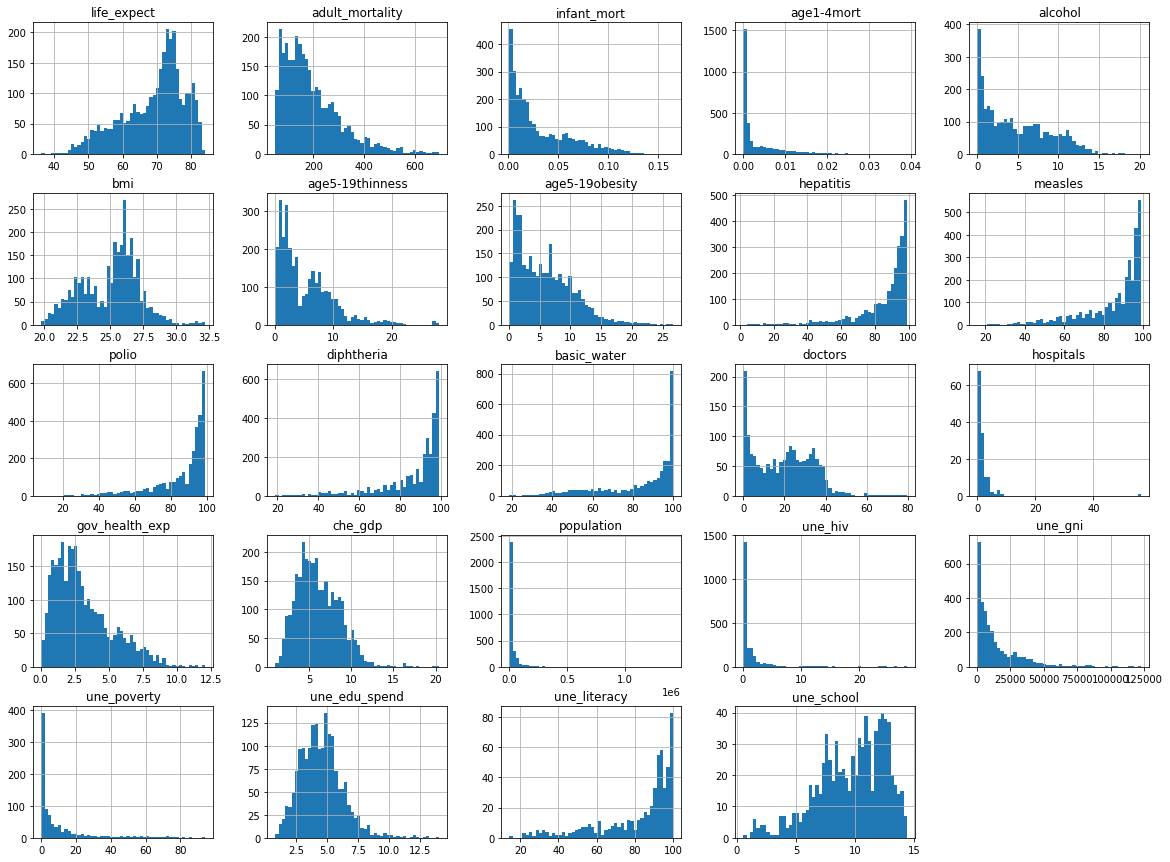

In [ ]:
# check distributions of predictors
df_dist_explore = df.drop(columns = ["region","year"])
df_dist_explore.hist(bins=50, figsize=(20,15))
plt.show()

#### Now that we gain some basic understandings of the dataset. It is time to clean the dataset.

## Data Cleaning

1. Drop highly correlated columns
2. Deal with columns with >= 80% missing values
3. Deal with other columns with missing values
4. **Turn categorical variable "region" to a treatment indicator of whether the counrty is in Africa**

In [ ]:
# 1. Drop highly correlated columns according to the correlation results above
df_drop = df

# drop both infant_mort, age1-4mort, and adult_mortality
df_drop = df_drop.drop(columns = ["infant_mort","age1-4mort","adult_mortality"])
# drop basic_water
df_drop = df_drop.drop(columns = ["basic_water"])

# choose 1 to drop between une_school and une_literacy
# because une_literacy has higher corr to the target variable, we drop une_school
df_drop = df_drop.drop(columns = ["une_school"])

# choose 1 to drop among measles, polio, and diphtheria
# because polio has higher corr to the target variable, we keep it and drop the other 2
df_drop = df_drop.drop(columns = ["measles","diphtheria"])

# df_drop = df_drop.drop(columns = ["infant_mort","age1-4mort","adult_mortality","basic_water","une_school","measles","diphtheria"])

In [ ]:
# 2. Deal with columns with >= 80% missing values
# The missing % of hospital and une_literacy is too high. We drop the two columns.
df_drop = df_drop.drop(columns = ["hospitals","une_literacy"])

#### From the histograms of predictors above, we can see that many predictors are skewed. Therefore, it is better to replacing the missing values with median values than using mean values.

In [ ]:
# 3. Deal with other columns with missing values
imputer = SimpleImputer(strategy="median")
df_drop_num = df_drop.drop("region", axis=1)
imputer.fit(df_drop_num)

# check median values calculation
diff = imputer.statistics_ - df_drop_num.median().values
print(diff)
print("median calculation OK")

# imputing medians
X = imputer.transform(df_drop_num)
df_imputed_num = pd.DataFrame(X, columns=df_drop_num.columns,
                          index=df_drop_num.index)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
median calculation OK


In [ ]:
# 4. Turning categorical variable "region" to treatment indicator
df_concat = pd.concat([df_imputed_num, df[["region"]]], axis=1)   # get "region" back

# if region == "Africa", label it as 1, otherwise 0
df_concat["treatment"] = np.where(df["region"]=="Africa", 1, 0)
df_prepared = df_concat.drop(columns = ["region"])

In [ ]:
df_prepared.head(5)

,year,life_expect,alcohol,bmi,age5-19thinness,age5-19obesity,hepatitis,polio,doctors,gov_health_exp,che_gdp,population,une_hiv,une_gni,une_poverty,une_edu_spend,treatment
0,2000.0,47.33730,1.47439,21.7,11.0,0.5,92.0,21.0,20.5235,1.11099,1.90860,16395.473,1.0,2530.0,32.3,2.60753,1
1,2001.0,48.19789,1.94025,21.8,10.9,0.5,92.0,28.0,20.5235,2.04631,4.48352,16945.753,1.1,2630.0,3.1,4.42541,1
2,2002.0,49.42569,2.07512,21.9,10.7,0.6,92.0,22.0,20.5235,1.30863,3.32946,17519.417,1.2,3180.0,3.1,4.42541,1
3,2003.0,50.50266,2.20275,22.0,10.5,0.7,92.0,21.0,20.5235,1.46560,3.54797,18121.479,1.3,3260.0,3.1,4.42541,1
4,2004.0,51.52863,2.41274,22.2,10.3,0.8,92.0,18.0,0.6210,1.68663,3.96720,18758.145,1.3,3560.0,3.1,4.42541,1


# CAUSAL TRY

In [ ]:
pd.Series(df_prepared['treatment']).value_counts(normalize=True)

0    0.743169
1    0.256831
Name: treatment, dtype: float64

In [ ]:
X = df_prepared.drop(columns = ["treatment","life_expect"])
treatment = df_prepared['treatment']
y = df_prepared['life_expect']

In [ ]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): -5.95 (-6.53, -5.37)


In [ ]:
X.shape

(3111, 15)

In [ ]:
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[04:11:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (XGBoost): -5.03 (-5.21, -4.85)


In [ ]:
X.shape

(3111, 15)

In [ ]:
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
 learning_rate_init=.1,
 early_stopping=True,
 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Neural Network (MLP)): 29.26 (24.73, 33.79)


In [ ]:
X.shape

(3111, 15)

In [ ]:
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


[04:11:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (BaseXRegressor using XGBoost): -4.55 (-4.71, -4.40)


In [ ]:
X.shape

(3111, 15)

In [ ]:
rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = rl.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[04:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (BaseRRegressor using XGBoost): 0.08 (0.07, 0.08)


In [ ]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor

In [ ]:
X.shape

(3111, 15)

In [ ]:
w_multi = np.array(['treated' if i==1 else 'control' for i in df_prepared.treatment])
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [ ]:
model_tau_feature = RandomForestRegressor() # specify model for model_tau_feature
feature_names = X.columns
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
 normalize=True, method='auto', features=feature_names)


{'treated': une_hiv            0.451623
 une_gni            0.235264
 age5-19thinness    0.080451
 polio              0.063971
 year               0.041257
 che_gdp            0.025291
 bmi                0.025113
 population         0.021379
 gov_health_exp     0.017276
 alcohol            0.014065
 age5-19obesity     0.012154
 doctors            0.004198
 hepatitis          0.004065
 une_edu_spend      0.003311
 une_poverty        0.000581
 dtype: float64}

array([-3.77260782])

# plotting

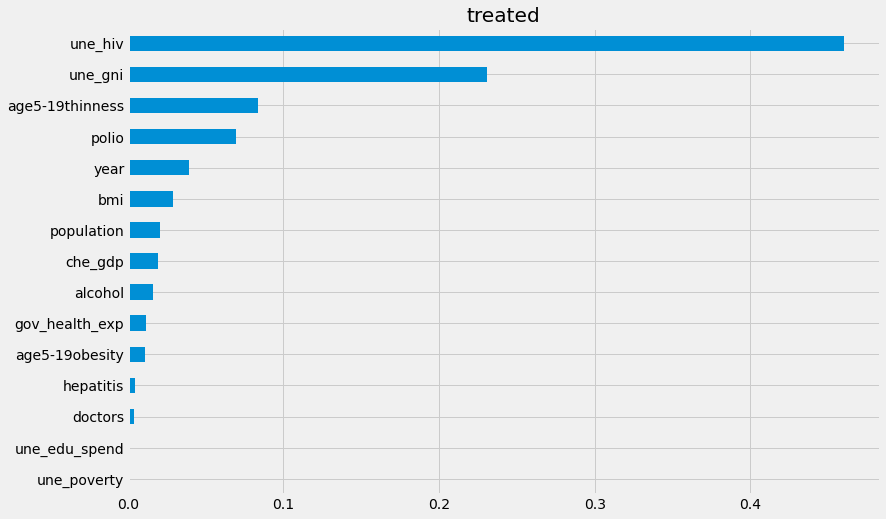

In [ ]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, features=feature_names, normalize=True, method='auto')

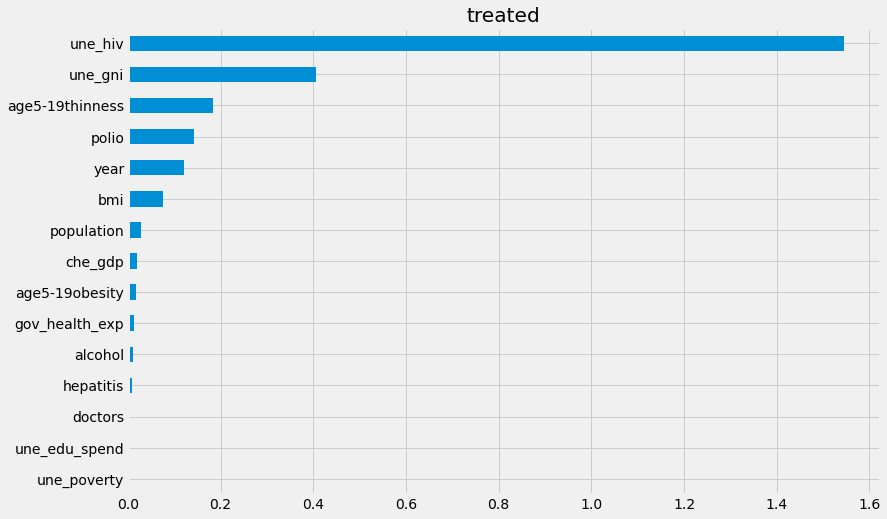

In [ ]:
# Using eli5's PermutationImportance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, features=feature_names, method='permutation')

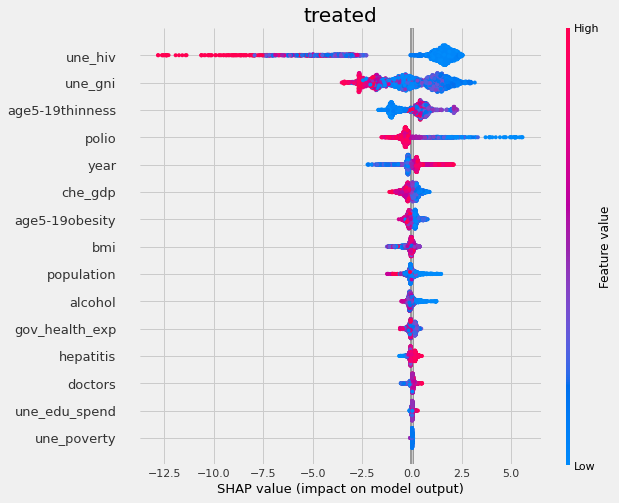

In [ ]:
# Using SHAP
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

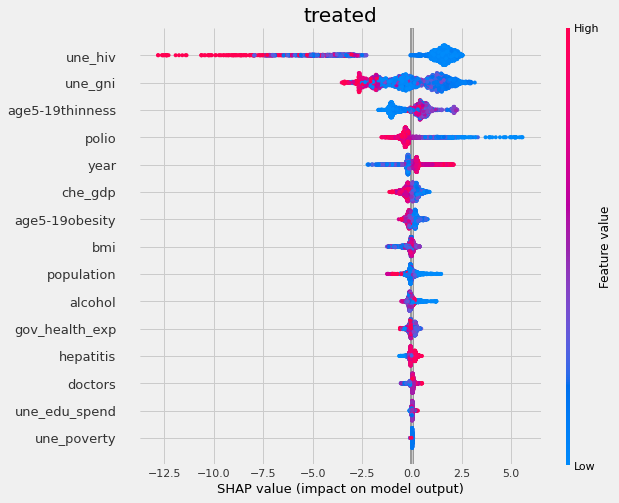

In [ ]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features=feature_names)

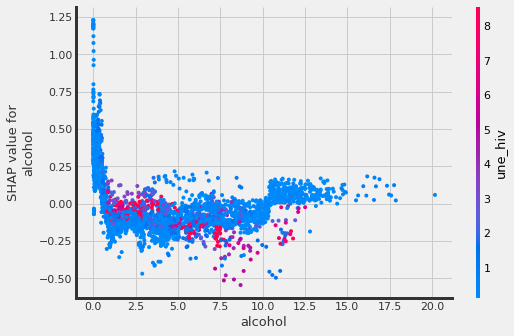

In [ ]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
slearner.plot_shap_dependence(treatment_group='treated',
 feature_idx=1,
 X=X,
 tau=slearner_tau,
 features=feature_names,
 interaction_idx='auto')

# Thank you for reading!